## Day 2: Split data by location

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import train_test_split

In [58]:
train_features = pd.read_csv('dengue_features_train.csv')
train_labels = pd.read_csv('dengue_labels_train.csv')
test_features = pd.read_csv('dengue_features_test.csv')

In [87]:
features = {
    "sj": [
        #'ndvi_ne',
        #'ndvi_nw',
        #'ndvi_se',
        #'ndvi_sw',
        'precipitation_amt_mm',
        'reanalysis_air_temp_k',
        'reanalysis_avg_temp_k',
        'reanalysis_dew_point_temp_k',
        'reanalysis_max_air_temp_k', 
        'reanalysis_min_air_temp_k',
        'reanalysis_precip_amt_kg_per_m2',
        'reanalysis_relative_humidity_percent',
        'reanalysis_sat_precip_amt_mm',
        'reanalysis_specific_humidity_g_per_kg',
        'reanalysis_tdtr_k',
        'station_avg_temp_c',
        'station_diur_temp_rng_c', 
        'station_max_temp_c',
        'station_min_temp_c',
        'station_precip_mm'
    ],
    "iq": [
        'ndvi_ne',
        'ndvi_nw',
        'ndvi_se',
        'ndvi_sw',
        'precipitation_amt_mm',
        'reanalysis_air_temp_k',
        'reanalysis_avg_temp_k',
        'reanalysis_dew_point_temp_k',
        'reanalysis_max_air_temp_k', 
        'reanalysis_min_air_temp_k',
        'reanalysis_precip_amt_kg_per_m2',
        'reanalysis_relative_humidity_percent',
        'reanalysis_sat_precip_amt_mm',
        'reanalysis_specific_humidity_g_per_kg',
        'reanalysis_tdtr_k',
        'station_avg_temp_c',
        'station_diur_temp_rng_c', 
        'station_max_temp_c',
        'station_min_temp_c',
        'station_precip_mm'
    ]
}

params = {
    "sj":{
        'iterations': [30, 50, 100],
        'learning_rate': [0.01, 0.05, 0.1],
        'depth': [3, 5]#,
        #'l2_leaf_reg': [1, 3, 6, 9]
    },
    "iq":{
        'iterations': [30, 50, 100, 300, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'depth': [3, 5, 7]
        #'l2_leaf_reg': [1, 3, 6, 9]
    }
}

pks = ['city', 'year', 'weekofyear']

In [60]:
def train_catboost(train_pool, eval_pool, params):    
    model = CatBoostRegressor()
    grid_search_result = model.grid_search(
        param_grid = params, 
        X = train_pool,
        cv = 3,
        verbose = 10)

    p = pd.DataFrame.from_dict(grid_search_result).params
    print(p)

    model = CatBoostRegressor(iterations = p.iterations,
                              learning_rate = p.learning_rate,
                              depth = p.depth)#,
                              #l2_leaf_reg = p.l2_leaf_reg)
    
    model.fit(train_pool, eval_set=eval_pool, verbose = 100)
    
    return model

In [61]:
def get_metrics(model, train_pool, eval_pool):
    train_metrics = model.eval_metrics(train_pool, ['RMSE'], ntree_start = model.tree_count_ - 1)
    test_metrics = model.eval_metrics(eval_pool, ['RMSE'], ntree_start = model.tree_count_ - 1)

    metrics = pd.DataFrame.from_dict(train_metrics)\
    .append(pd.DataFrame.from_dict(test_metrics), ignore_index=True)\
    .transpose().rename(columns={0:'Train', 1:'Test'})
    return metrics

In [171]:
def split_data_city(city, train_features, train_labels, features, remove_outliers):
    city_train_features = train_features[train_features.city == city].reset_index(drop = True).copy()
    city_train_labels = train_labels[train_labels.city == city].reset_index(drop = True).copy()

    if(remove_outliers):
        upper_bound = city_train_labels.total_cases.mean() + (city_train_labels.total_cases.std() * 3)
        without_outliers = city_train_labels.total_cases < upper_bound

        city_train_features = city_train_features[without_outliers]
        city_train_labels = city_train_labels[without_outliers]
        
    splitted_data = train_test_split(city_train_features[features], city_train_labels.total_cases, test_size=0.2)
    train_data, eval_data, train_target, eval_target = splitted_data

    train_pool = Pool(data = train_data, label = train_target)
    eval_pool = Pool(data = eval_data, label = eval_target)
    return (train_pool, eval_pool)

In [172]:
def train_city(city, train_features, train_labels, features, params, remove_outliers = False):
    print(city)
    train_pool, eval_pool = split_data_city(city, train_features, train_labels, features[city], remove_outliers)

    model = train_catboost(train_pool, eval_pool, params[city])
    model.save_model(city)

    metrics = get_metrics(model, train_pool, eval_pool)

    print(metrics)
    print(model.get_feature_importance(prettified = True))
    return model

In [173]:
def predict_city(city, test_features, features, pks):
    city_test_features = test_features[test_features.city == city].reset_index(drop = True).copy()
    model = CatBoostRegressor()
    model.load_model(city)
    test_pred = model.predict(city_test_features[features[city]])
    test_pred = pd.DataFrame(test_pred).rename(columns = {0:'total_cases'}).total_cases.map(round)
    result = pd.concat([city_test_features[pks], test_pred], axis = 1)
    return result

In [88]:
train_city('sj', train_features, train_labels, features, params)

sj
0:	loss: 77.1009173	best: 77.1009173 (0)	total: 129ms	remaining: 2.2s
10:	loss: 71.2631642	best: 67.5250389 (8)	total: 562ms	remaining: 358ms
17:	loss: 67.0849592	best: 67.0849592 (17)	total: 1.27s	remaining: 0us
Estimating final quality...
depth                5.0
iterations         100.0
learning_rate        0.1
test-RMSE-mean       NaN
test-RMSE-std        NaN
train-RMSE-mean      NaN
train-RMSE-std       NaN
Name: params, dtype: float64
0:	learn: 49.5809555	test: 55.7974633	best: 55.7974633 (0)	total: 2.25ms	remaining: 223ms
99:	learn: 31.8631735	test: 53.2969549	best: 53.1885095 (95)	total: 174ms	remaining: 0us

bestTest = 53.18850955
bestIteration = 95

Shrink model to first 96 iterations.
          Train      Test
RMSE  32.303245  53.18851
                               Feature Id  Importances
0                      station_max_temp_c    11.174427
1                       reanalysis_tdtr_k    10.786363
2         reanalysis_precip_amt_kg_per_m2    10.490100
3   reanalysis_speci

In [85]:
train_city('iq', train_features, train_labels, features, params)

iq
0:	loss: 8.0059848	best: 8.0059848 (0)	total: 127ms	remaining: 5.59s
10:	loss: 6.8793521	best: 6.7333173 (8)	total: 977ms	remaining: 3.02s
20:	loss: 6.8870490	best: 6.7240185 (11)	total: 2.82s	remaining: 3.22s
30:	loss: 8.1126990	best: 6.7240185 (11)	total: 7.79s	remaining: 3.52s
40:	loss: 6.8924313	best: 6.6855350 (32)	total: 14.1s	remaining: 1.38s
44:	loss: 6.6855350	best: 6.6855350 (32)	total: 24.2s	remaining: 0us
Estimating final quality...
depth               7.0
iterations         30.0
learning_rate       0.1
test-RMSE-mean      NaN
test-RMSE-std       NaN
train-RMSE-mean     NaN
train-RMSE-std      NaN
Name: params, dtype: float64
0:	learn: 9.7843033	test: 13.6610794	best: 13.6610794 (0)	total: 8.33ms	remaining: 242ms
29:	learn: 6.8699660	test: 13.3953653	best: 13.3826578 (24)	total: 187ms	remaining: 0us

bestTest = 13.38265783
bestIteration = 24

Shrink model to first 25 iterations.
         Train       Test
RMSE  7.201397  13.382658
                               Feature Id

In [129]:
cities = train_features.city.unique()
result = pd.DataFrame()
for c in cities:
    result = result.append(predict_city(c, test_features, features, pks))

In [130]:
result

,city,year,weekofyear,total_cases
0,sj,2008,18,27
1,sj,2008,19,20
2,sj,2008,20,24
3,sj,2008,21,39
4,sj,2008,22,22
...,...,...,...,...
151,iq,2013,22,10
152,iq,2013,23,6
153,iq,2013,24,6
154,iq,2013,25,7


In [131]:
result.to_csv('output_day2.csv', index=False)

#### Woo! I scored 27.8317 on 'DengAI: Predicting Disease Spread'!

## Checking for outliers

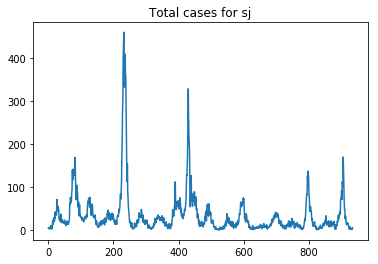

mean:  34.18055555555556
sd:  51.38137249715158
upper bound:  188.32467304701032
outliers: 
    city  year  weekofyear  total_cases
227   sj  1994          36          202
228   sj  1994          37          272
229   sj  1994          38          302
230   sj  1994          39          395
231   sj  1994          40          426
232   sj  1994          41          461
233   sj  1994          42          381
234   sj  1994          43          333
235   sj  1994          44          353
236   sj  1994          45          410
237   sj  1994          46          364
238   sj  1994          47          359
239   sj  1994          48          288
240   sj  1994          49          221
428   sj  1998          30          191
429   sj  1998          31          256
430   sj  1998          32          329
431   sj  1998          33          263
432   sj  1998          34          220
433   sj  1998          35          204


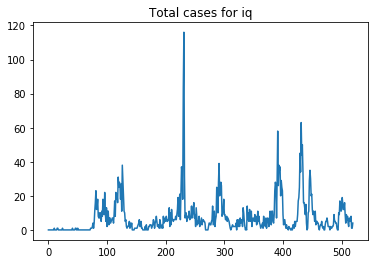

mean:  7.565384615384615
sd:  10.765478342208679
upper bound:  39.86181964201065
outliers: 
    city  year  weekofyear  total_cases
230   iq  2004          49           83
231   iq  2004          50          116
391   iq  2008           2           58
429   iq  2008          40           45
431   iq  2008          42           63
432   iq  2008          43           44
433   iq  2008          44           50


In [165]:
cities = train_features.city.unique()
for c in cities:
    city_train_features = train_features[train_features.city == c].reset_index(drop = True).copy()
    city_train_labels = train_labels[train_labels.city == c].reset_index(drop = True).copy()
    city_train_labels.total_cases.plot(title = 'Total cases for ' + c)
    plt.show()
    print('mean: ', city_train_labels.total_cases.mean())
    print('sd: ', city_train_labels.total_cases.std())
    print('upper bound: ', (city_train_labels.total_cases.mean() + (city_train_labels.total_cases.std() * 3)))
    print('outliers: ')
    print(city_train_labels[city_train_labels.total_cases > (city_train_labels.total_cases.mean() + (city_train_labels.total_cases.std() * 3))])

In [176]:
features = {
    "sj": [
        'ndvi_ne',
        'ndvi_nw',
        'ndvi_se',
        'ndvi_sw',
        'precipitation_amt_mm',
        'reanalysis_air_temp_k',
        'reanalysis_avg_temp_k',
        'reanalysis_dew_point_temp_k',
        'reanalysis_max_air_temp_k', 
        'reanalysis_min_air_temp_k',
        'reanalysis_precip_amt_kg_per_m2',
        'reanalysis_relative_humidity_percent',
        'reanalysis_sat_precip_amt_mm',
        'reanalysis_specific_humidity_g_per_kg',
        'reanalysis_tdtr_k',
        'station_avg_temp_c',
        'station_diur_temp_rng_c', 
        'station_max_temp_c',
        'station_min_temp_c',
        'station_precip_mm'
    ],
    "iq": [
        'ndvi_ne',
        'ndvi_nw',
        'ndvi_se',
        'ndvi_sw',
        'precipitation_amt_mm',
        'reanalysis_air_temp_k',
        'reanalysis_avg_temp_k',
        'reanalysis_dew_point_temp_k',
        'reanalysis_max_air_temp_k', 
        'reanalysis_min_air_temp_k',
        'reanalysis_precip_amt_kg_per_m2',
        'reanalysis_relative_humidity_percent',
        'reanalysis_sat_precip_amt_mm',
        'reanalysis_specific_humidity_g_per_kg',
        'reanalysis_tdtr_k',
        'station_avg_temp_c',
        'station_diur_temp_rng_c', 
        'station_max_temp_c',
        'station_min_temp_c',
        'station_precip_mm'
    ]
}

params = {
    "sj":{
        'iterations': [30, 50, 100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'depth': [3, 5, 7]#,
        #'l2_leaf_reg': [1, 3, 6, 9]
    },
    "iq":{
        'iterations': [30, 50, 100, 300, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'depth': [3, 5, 7]
        #'l2_leaf_reg': [1, 3, 6, 9]
    }
}

pks = ['city', 'year', 'weekofyear']

In [177]:
train_city('sj', train_features, train_labels, features, params, remove_outliers = True)

sj
0:	loss: 31.7922442	best: 31.7922442 (0)	total: 131ms	remaining: 5.75s
10:	loss: 24.3907896	best: 24.3907896 (10)	total: 827ms	remaining: 2.55s
20:	loss: 24.5777431	best: 24.3290049 (13)	total: 2.07s	remaining: 2.36s
30:	loss: 32.2325021	best: 24.2022188 (26)	total: 5.38s	remaining: 2.43s
40:	loss: 24.7128692	best: 24.2022188 (26)	total: 10.3s	remaining: 1s
44:	loss: 24.7595569	best: 24.2022188 (26)	total: 16.2s	remaining: 0us
Estimating final quality...
depth                5.0
iterations         200.0
learning_rate        0.1
test-RMSE-mean       NaN
test-RMSE-std        NaN
train-RMSE-mean      NaN
train-RMSE-std       NaN
Name: params, dtype: float64
0:	learn: 28.2601343	test: 30.8032024	best: 30.8032024 (0)	total: 3.23ms	remaining: 643ms
100:	learn: 19.8210314	test: 29.8053809	best: 29.7840642 (93)	total: 205ms	remaining: 201ms
199:	learn: 14.2708578	test: 29.8319919	best: 29.6597080 (182)	total: 377ms	remaining: 0us

bestTest = 29.65970798
bestIteration = 182

Shrink model to 

In [175]:
train_city('iq', train_features, train_labels, features, params, remove_outliers = True)

iq
0:	loss: 7.8003926	best: 7.8003926 (0)	total: 146ms	remaining: 6.4s
10:	loss: 6.4724010	best: 6.4680259 (9)	total: 1.01s	remaining: 3.13s
20:	loss: 6.3897680	best: 6.3897680 (17)	total: 2.78s	remaining: 3.18s
30:	loss: 7.9791116	best: 6.3897680 (17)	total: 7.71s	remaining: 3.48s
40:	loss: 6.5241967	best: 6.3897680 (17)	total: 14s	remaining: 1.37s
44:	loss: 6.6172453	best: 6.3897680 (17)	total: 24s	remaining: 0us
Estimating final quality...
depth               5.0
iterations         30.0
learning_rate       0.1
test-RMSE-mean      NaN
test-RMSE-std       NaN
train-RMSE-mean     NaN
train-RMSE-std      NaN
Name: params, dtype: float64
0:	learn: 7.9929453	test: 7.0417253	best: 7.0417253 (0)	total: 2.83ms	remaining: 82ms
29:	learn: 6.4498405	test: 7.0730095	best: 6.9634452 (6)	total: 60ms	remaining: 0us

bestTest = 6.963445161
bestIteration = 6

Shrink model to first 7 iterations.
         Train      Test
RMSE  7.434832  6.963445
                               Feature Id  Importances
0 

In [178]:
cities = train_features.city.unique()
result = pd.DataFrame()
for c in cities:
    result = result.append(predict_city(c, test_features, features, pks))

In [179]:
result.to_csv('output_day2_without_outliers.csv', index=False)

#### Woo! I scored 27.7043 on 'DengAI: Predicting Disease Spread'!

- Can't remove outliers, need to trait the problem as time series
- Or maybe fit a model to estimate peaks and another to estimate normal cases
- Maybe the calculated features resolve this

Create a model splitted by location (DONE)

Calculate for last_week, last_two_weeks, last_month: (TODO)
- precipitation
- temperature
- humidity
